<h2>Calculating Mu & Edge Detection<H2>

Description: The following script automates the process of generating the mu values for the edges detected off each tif image taken from the experiments held in Emory.

<p>Imports required for runnining script. Utilize yml file for setting up virtual environment<p>

In [29]:
from decimal import ROUND_UP
import math
import cv2
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import zscore
import pandas as pd
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
from scipy.special import lambertw
import os
import csv
from csv import writer

<p>Following methods performs Canny edge detection on the images<p>

In [30]:
def edge_detection(img):
    #Performs Canny Edgetection on the Image
    med_val = np.median(img)
    lower = int(max(0,1.9*med_val))
    upper = int(min(255,1.9*med_val))
    edges = cv2.Canny(image = img, threshold1 = lower, threshold2 = upper + 100)
    #Crop images to remove noise from beyond the container 
    output = edges[119:330]
    return output

<p>Perform Hough Transform on Canny Edge Detection to further remove noise and extract clearer edges<p>

In [31]:
def houghTransform(output):
    #Create a plain back image to place lines detecting from images passed in as parameter
    cdstP = np.zeros((300,1500,3))
    
    #HoughTransform
    linesP = cv2.HoughLinesP(output,rho = 1,theta = 1*np.pi/180,threshold = 15,minLineLength = 10,maxLineGap = 20)
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)

    return cdstP

<p>Some tif images have vertical lines due to the edge pushing against the ice cubes...this method removes this vertical line to only extract the edges required<p>

In [32]:
def remove_line(output):
    #Creating Kernel for detecting vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
    x=cv2.morphologyEx(output, cv2.MORPH_OPEN, vertical_kernel ,iterations=1)
    #Remove the detected vertical lines from original image
    output-=x
    return output

<p>The following is the equation utilized to curve fit (as pulled from powerpoint)...the method is utilized in the fitting function to curve fit the data points collected from the edge detection to this equation<p>

In [33]:
def equation2(x,a):
    new_x = []
    #Math.exp cannot take in list, so we have to iterate through the x_coordinates apply the function to each
    #and then spit out a corresponding y coordinate
    cmtopixel=16
    x = (x[-1] - x)/cmtopixel #flip direction of x (to match eqn) and convert to cm
    L = np.max(x)
    W = 27
    H_L = 1
    
    for item in x: #Equation pulled from powerpoint
        output =  math.exp(-(a*(L - item)/W)-0.5)
        output2 = -0.5*output
        output3 = H_L/(2*np.real(lambertw(output2)))
        new_x.append(output3*cmtopixel)
    
    y_out = new_x
    return y_out

<p> The following function pulls (x,y) coordinates from edge detection, performs outlier removals, put the values into pandas frameworks,and then utilizes the scipy library function to curve fit the data point to the equation in equation2 method above. <p>

In [34]:
def fitting(output):
    #Gather the x,y coordinates of the edges detected in images
    indices = np.where(output != [0])
    coordinates = list(zip(indices[1], indices[0]))

    #Place xoordinates into a pandas dataframe
    df = pd.DataFrame(coordinates, columns = ["X", "Y"])
    
    #Remove outliers from x and y coordinates
    z_scores = zscore(df)
    abs = np.abs(z_scores)
    filter = (abs < 2).all(axis=1)
    new_df = df[filter]
    

    #Move x coordinates from pandas framework to numpy format
    x_coordinates = new_df['X']
    x_coordinates1 = []
    for item in x_coordinates:
        x_coordinates1.append(item)
    x_coordinates2 = np.array(x_coordinates1)
    
    #Move y coordinates from pandas framework to numpy format
    y_coordinates = new_df['Y']
    y_coordinates1 = []
    for item in y_coordinates:
        y_coordinates1.append(item)
    y_coordinates2 = np.array(y_coordinates1)
    
    #Utilizng the x and y coordiantes apply curve fitting with equation inputed
    popt, cov = curve_fit(equation2, x_coordinates2, -y_coordinates2)
    a = popt
    y_new_value = equation2(sorted(x_coordinates2), a)
    #COMMENT OUT TO SEE RESULTS FROM CURVE FITTING
    #plt.scatter(x_coordinates2, -y_coordinates2, s = 0.1)
    #plt.plot(sorted(x_coordinates2), y_new_value, color = "red")
    #plt.show()
    return a

<p>The code here serves as the "main" method calling on the other methods above. It is automated to iterate through a file of tif files and create csv files for each tiff file storing the image number and associated mu value.<p>

NA


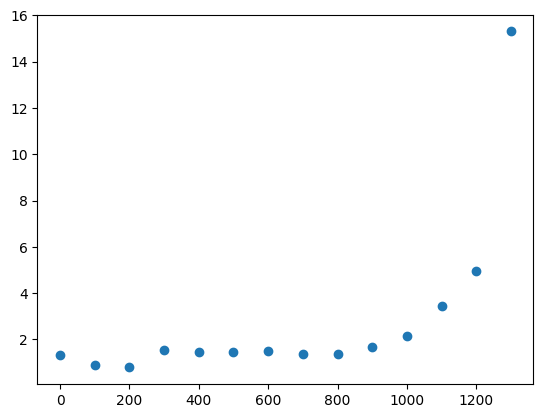

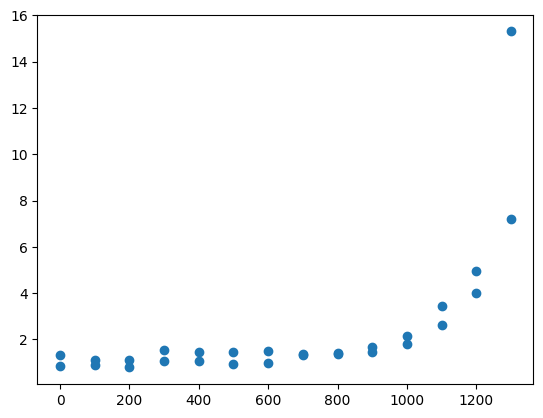

In [35]:
#Automatically pulling in images from file
fileNum = 1 
#change path accordingly to folder with tif files
path = "/Users/ayushirajpoot/Desktop/ResearchNotebook/CalculatingMu/ResearchImages"
for filename in os.scandir(path):
    fileString = "File" + str(fileNum) #Name files File(#Number)
    fileNum = fileNum + 1
    with open(fileString,'w') as file: #Create csv file
        writer_object = writer(file) 
        writer_object.writerow(["Image Number", "Mu Value"])
        if filename.is_file():
            im = Image.open(filename.path)
        im = Image.open(filename.path)
        counter = 0
        for i, page in enumerate(ImageSequence.Iterator(im)): #Iterate through tiff images in the tiff files
            if counter%100 == 0: #Set for every 100 image a mu value is calculated change accordingly -> change 100 to your preference
                img = np.array(page)
                #COMMENT OUT THE FOLLOWING RESULTS TO PRINT RESULTS FOR EDGE DETECTION
                output = edge_detection(img)
                #cv2.imshow("edgeDetection", output)
                #cv2.waitKey(0)
                #cv2.destroyAllWindows()
                output2 = houghTransform(output)
                #cv2.imshow("houghTransform", output2)
                #cv2.waitKey(0)
                #cv2.destroyAllWindows()
                output3 = remove_line(output2)
                #cv2.imshow("remove line", output3)
                #cv2.waitKey(0)
                #cv2.destroyAllWindows()
                try:
                    value = fitting(output3) #curve fit after edge detection
                    writer_object.writerow([i, value[0]])
                except:
                    print("NA")
                counter = counter + 1
            else:
                counter = counter + 1
   
#Following code opens each csv file one at a time and constructs a visual matplotlib graph             
x_coordinate = []
y_coordinate = []
coordinates = []
i = 0
for p in range(fileNum):
    if (p != 0) :
        fileString = "File" + str(p)
        i = 0
        with open(fileString, mode='r') as csv_file:
            for line in csv_file:
                tokens = line.split( "," )
                if i != 0 :
                    x_coordinate.append(int(tokens[0]))
                    y_coordinate.append(float(tokens[1]))
                    coordinates.append(line)
                i = 1
        x_coordinate2 = np.array(x_coordinate)
        y_coordinate2 = np.array(y_coordinate)
        #print(x_coordinate2)
        #print(y_coordinate2)
        plt.scatter(x_coordinate2, y_coordinate2)
        plt.show()